# Imports

In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from gymnasium.utils.save_video import save_video

c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


# Environment

Create the environment. You can use any ATARI environment from [here](https://gymnasium.farama.org/environments/atari/), but prefer to use environments with discrete action space with fewer actions.

In [3]:
env = gym.make('ALE/AirRaid-v5', render_mode='rgb_array')
eval_env = gym.make('ALE/AirRaid-v5')

c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


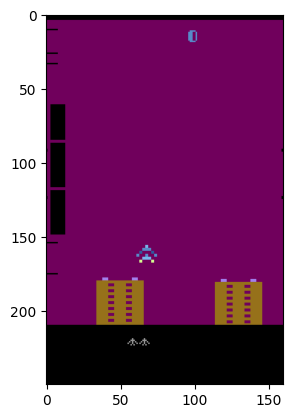

In [4]:
env.reset()
plt.imshow(env.render())

# Replay Buffer

Create a replay buffer to hold game history

In [5]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = None):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.max_size = max_size
        self.done = np.zeros(max_size)
        self.step = 0
        self.rng = np.random.default_rng(seed=seed)
        self.len = 0

        self.current_state = np.zeros((max_size, *observation_space.shape))
        self.action = np.zeros((max_size, *action_space.shape), dtype=int)
        self.reward = np.zeros(max_size)
        self.next_state = np.zeros((max_size, *observation_space.shape))
        
    def add(self, current_observation: np.ndarray, action: int, reward: float, next_observation: np.ndarray, done: bool) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observation: environment state observed at the current step
            action: action taken by the model
            reward: reward received after taking the action
            next_observation: environment state obversed after taking the action
            done: whether the episode has ended or not"""
        self.current_state[self.step] = current_observation
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_observation
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, done"""
        indicies = self.rng.choice(self.len, size=n_samples, replace=replace)
        return (
            self.current_state[indicies], 
            self.action[indicies], 
            self.reward[indicies], 
            self.next_state[indicies], 
            self.done[indicies]
        )

    def clear(self) -> None:
        """Clears the buffer"""
        self.step = self.len = 0

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observation, action, reward, next observation, done"""
        return (
            self.current_state[index], 
            self.action[index], 
            self.reward[index], 
            self.next_state[index], 
            self.done[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""
        return self.len

# Model

Implement your model. Most if not all ATARI environments have an image observation

In [6]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '/') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [7]:
def get_model(
    input_features: tuple | int, 
    features: int,
    out_features: tuple | int,
    blocks: int, 
    dropout: float = 0.2,
    multiply_freq: int = 1,
    name: str | None = None
) -> tf.keras.Model:
    inputs = x = tf.keras.layers.Input(input_features, name=get_name(name, 'input'))

    for i in range(blocks):
        x = tf.keras.layers.Conv2D(features, 3, padding='same', name=get_name(name, f'conv2d_1st_{i}'))(x)
        x = tf.keras.layers.Conv2D(features, 3, padding='same', name=get_name(name, f'conv2d_2st_{i}'))(x)
        x = tf.keras.layers.PReLU(name=get_name(name, f'PReLU_1st_{i}'))(x)
        x = tf.keras.layers.MaxPool2D((2, 2), name=get_name(name, f'maxPOOL2d_{i}'))(x)
        
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'dropout_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            features *= 2

    x = tf.keras.layers.MaxPool2D((2, 2), name=get_name(name, f'maxPOOL2d_final'))(x)
    x = tf.keras.layers.Flatten(name=get_name(name, 'flattenidze'))(x)
    x = tf.keras.layers.Dense(out_features, name=get_name(name, 'prediction'))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

# Sampler

Implement the sampler

In [8]:
class Sampler:
    
    def __init__(self, epsilon: float, seed: int | None = None):
        """Selects a random action with probability `epsilon` otherwise selects the most probably action given by the model.

        Parameters:
            epsilon: the probability to select a random action
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.rng = np.random.default_rng(seed=seed)
        self.epsilon = epsilon
        
    def __call__(self, probabilities: np.ndarray) -> int:
        """Select an action given the `probabilities

        Parameters:
            probabilities: probabilities for each action

        Returns:
            index of the selected action"""

        if self.rng.random() < self.epsilon:
            return self.rng.integers(probabilities.shape[-1])
        return np.argmax(probabilities)

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [9]:
def play_game(model: tf.keras.Model, buffer: ReplayBuffer | None, env: gym.Env, max_steps: int, sampler: Sampler, observation: np.ndarray | None = None) -> np.ndarray:
    """Play game and record

    Parameters:
        model: the model to get actions with
        buffer: replay buffer to store the entries to
        env: environment to play
        max_steps: maximal number of steps to perform
        sampler: sampler to use to sample actions
        observation: the observation to resume from

    Returns:
        the last observation"""
    if observation is None:
        observation, _ = env.reset()

    buffer = buffer if buffer is not None else ReplayBuffer(1)

    for i in range(max_steps):
        a = sampler(model(observation[None], training=False).numpy()[0])
        
        new_observation, score, done, terminated, _ = env.step(a)
        
        buffer.add(observation, a, score, new_observation, done)

        if done or terminated:
            observation, _ = env.reset()
            continue
            
        observation = new_observation

    return observation

# Loss

Implement double q learning loss

In [10]:
def qq_loss(
    current_observation: tf.Tensor, 
    action: tf.Tensor, 
    reward: tf.Tensor, 
    next_observation: tf.Tensor, 
    done: tf.Tensor,
    model: tf.keras.Model,
    target_model: tf.keras.Model,
    gamma: float
) -> tf.Tensor:
    """Computes double q learning loss.

    Parameters:
        current_observation: observations at the current time step
        action: actions taken at the current time step
        reward: rewards at the current time step
        next_observation: observations at the next time step
        done: whether the episode has ended or not
        model: trainig model
        target_model: target model
        gamma: discount

    Returns:
        Computed loss"""
    q_current = model(current_observation)
    q_next = target_model(next_observation)

    a_next = tf.argmax(model(next_observation), axis=-1)
    
    q_ref = reward + gamma * tf.reshape(tf.gather(q_next, tf.expand_dims(a_next, axis=-1), batch_dims=1), (-1, )) * (1. - done) # Оценка от таргет модели предсказанных действий основной моделью
    
    q = tf.reshape(tf.gather(q_current, tf.expand_dims(action, axis=-1), batch_dims=1), (-1, )) # Оценка от основной модели предсказанных действий

    return tf.math.reduce_mean(tf.square(q_ref - q))

# Training

Create models, replay buffers, sampler, optimizer, epsilon decay etc. Implement training loop, show training progress and perform model evaluation once in a while

In [11]:
model = get_model(env.observation_space.shape, 8, 6, 3, name='fuck_UFO', multiply_freq=2)

c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


In [12]:
model.summary()

Model: "fuck_UFO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fuck_UFO/input (InputLayer)  [(None, 250, 160, 3)]    0         
                                                                 
 fuck_UFO/conv2d_1st_0 (Conv  (None, 250, 160, 8)      224       
 2D)                                                             
                                                                 
 fuck_UFO/conv2d_2st_0 (Conv  (None, 250, 160, 8)      584       
 2D)                                                             
                                                                 
 fuck_UFO/PReLU_1st_0 (PReLU  (None, 250, 160, 8)      320000    
 )                                                               
                                                                 
 fuck_UFO/maxPOOL2d_0 (MaxPo  (None, 125, 80, 8)       0         
 oling2D)                                                 

In [13]:
target_model = get_model(env.observation_space.shape, 8, 6, 3, name='target_fuck_UFO', multiply_freq=2)

In [14]:
target_model.trainable = False
target_model.set_weights(model.get_weights())

In [15]:
train_buffer = ReplayBuffer(10000, observation_space=env.observation_space, action_space=env.action_space)
train_sampler = Sampler(1)

In [16]:
eval_buffer = ReplayBuffer(100, observation_space=eval_env.observation_space, action_space=eval_env.action_space)
eval_sampler = Sampler(0)

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4, clipnorm=5, decay=2e-5)

In [18]:
epochs = 20000
batch_size = 64
decay_epochs = epochs // 2
end_epsilon = 0.1
update_frequency = 512
eval_frequency = 512
steps_per_epoch = 32
eval_steps = 1000
initial_samples = 1000
n_evals = 5
eval_threshold = 200
epsilon_decay = tf.keras.optimizers.schedules.PolynomialDecay(1., decay_epochs, end_learning_rate=end_epsilon)

In [19]:
losses = []
total_loss = 0
eval_score = 0

s, _ = env.reset()
pbar = tqdm.trange(epochs)
for i in pbar:
    train_sampler.epsilon = epsilon_decay(i).numpy()
    
    s = play_game(model, train_buffer, env, steps_per_epoch, train_sampler, observation=s)
    
    vals = train_buffer.sample(batch_size)
    with tf.GradientTape(watch_accessed_variables=False) as g:
        g.watch(model.trainable_weights)
        loss = qq_loss(*vals, model, target_model, 0.99)
        
    gradient = g.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradient, model.trainable_weights))
    
    losses.append(loss.numpy())
    total_loss += losses[-1]

    if (i + 1) % update_frequency == 0:
        target_model.set_weights(model.get_weights())

    if (i + 1) % eval_frequency == 0:
        eval_score = 0

        for i in range(n_evals):
            eval_buffer.clear()
            play_game(model, eval_buffer, eval_env, eval_steps, eval_sampler)
            eval_score += eval_buffer.reward[:len(eval_buffer)].sum()

        eval_score /= n_evals
        if eval_score >= eval_threshold:
            break

    pbar.set_description(f'L: {losses[-1]:.5f}; AL: {total_loss / (i + 1):.5f}; E: {eval_score:.5f}')

  0%|          | 0/20000 [00:00<?, ?it/s]

In [20]:
eval_score

240.0

In [21]:
model.save_weights(f'./models/atari_model_{eval_score}')

# Testing

Test the model on the environment and get a cool video

In [22]:
def save_gameplay(model: tf.keras.Model, render_mode: str = 'human', n_frames: int = 1000, buffer_capacity: int = 1000):
    env = gym.make('ALE/AirRaid-v5', render_mode=render_mode)
    buffer = ReplayBuffer(buffer_capacity, env.observation_space, env.action_space)
    play_game(model, buffer, env, n_frames, Sampler(0))
    # save_video(env.render(), './videos', durations=[1] * len(), fps=24) if you wanna use this line change 'render_mode' -> 'rgb_array_list'
    return buffer

In [ ]:
model.load_weights('./models/atari_model')

In [28]:
buffer = save_gameplay(model)

In [29]:
buffer.reward.sum()

2075.0